In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
bank = pd.read_csv('https://raw.githubusercontent.com/christianolivamoya/MIAX11-ML/main/data/bank.csv', sep=';')
bank.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1539,34,blue-collar,married,secondary,no,322,yes,no,cellular,20,apr,10,3,-1,0,unknown,no
3646,48,blue-collar,single,secondary,no,312,yes,yes,cellular,3,feb,369,2,-1,0,unknown,no
283,42,admin.,divorced,secondary,no,63,no,no,unknown,16,may,88,6,-1,0,unknown,no
4209,38,services,married,secondary,no,0,no,yes,cellular,16,jul,1473,6,-1,0,unknown,no
1331,42,self-employed,married,secondary,no,97,no,no,cellular,10,jul,108,2,-1,0,unknown,no


In [3]:
bank.drop(columns=['day', 'month'], inplace=True)
educ_mapping = {'unknown':0,
                'primary':1,
                'secondary':2,
                'tertiary':3}
noyes_mapping = {'no':False, 'yes':True}
bank['education'].replace(educ_mapping, inplace=True)
bank['y'].replace(noyes_mapping, inplace=True) # Cambio el target a True (1) o False (0)
bank['default'].replace(noyes_mapping, inplace=True)
bank['housing'].replace(noyes_mapping, inplace=True)
bank['loan'].replace(noyes_mapping, inplace=True)

features = bank.drop(columns='y')
target = bank['y']

features = pd.get_dummies(features)
features.sample(5)

<ipython-input-3-71c2651dea92>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bank['education'].replace(educ_mapping, inplace=True)
<ipython-input-3-71c2651dea92>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank['education'].replace(educ_mapping, inplace=True)
<ipython-input-3-71c2651dea92>:8

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
251,32,3,False,2349,False,False,134,5,-1,0,...,False,True,False,True,False,False,False,False,False,True
794,29,2,False,908,True,False,1663,1,-1,0,...,False,False,True,False,False,True,False,False,False,True
1533,32,2,False,1721,True,False,650,2,-1,0,...,False,False,True,False,False,True,False,False,False,True
4505,32,2,False,620,True,False,1234,3,-1,0,...,False,False,True,False,False,True,False,False,False,True
1503,56,2,False,-113,True,True,614,2,-1,0,...,False,True,False,True,False,False,False,False,False,True


In [4]:
dataset_x = []
dataset_x.append(features.values[target==True])
dataset_x.append(features.values[target==False][:521])
dataset_x = np.concatenate(dataset_x)
dataset_x = pd.DataFrame(dataset_x, columns=features.columns)
dataset_y = np.array([True]*521 + [False]*521)
dataset_y = pd.Series(dataset_y, name="y")
dataset_x.shape, dataset_y.shape

((1042, 32), (1042,))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2)

means = x_train.mean()
stds = x_train.std()
x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

# Modelo base

In [6]:
base_tree = DecisionTreeClassifier()
base_tree.fit(x_train, y_train)
base_tree.score(x_test, y_test)

0.7559808612440191

# Bagging

El bagging consiste en realizar un muestreo aleatorio con reemplazo, del mismo tamaño que el dataset original.

In [7]:
def bagging(num_clasificadores, X_train, y_train):
  bagging_x = []
  bagging_y = []
  for _ in range(num_clasificadores):
    # Importante: replace = TRUE
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    bagging_x.append(X_train[indices])
    bagging_y.append(y_train[indices])

  return bagging_x, bagging_y

## Entrenamiento de conjunto de clasificadores

Cada clasificador se entrena con cada uno de los datasets generados con bagging.

In [8]:
NUM_CLASIFICADORES = 101

bagging_x, bagging_y = bagging(NUM_CLASIFICADORES, x_train.values, y_train.values)

In [9]:
conjunto_clasificadores = []
for i in range(NUM_CLASIFICADORES):
  tree = DecisionTreeClassifier()
  tree.fit(bagging_x[i], bagging_y[i])
  conjunto_clasificadores.append(tree)

## Evaluación de conjunto de clasificadores

Cada clasificador da su predicción al mismo dataset de test (o validación).

In [10]:
preds = []
for cl in conjunto_clasificadores:
  preds.append(cl.predict(x_test.values))
preds = np.array(preds)

In [11]:
pred_conjunto = (preds.mean(axis=0) > 0.5)*1

In [12]:
acc = np.mean(pred_conjunto == y_test)
acc

np.float64(0.8038277511961722)

## Curva de accuracy según número de clasificadores

In [13]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl in conjunto_clasificadores[:i]:
    preds.append(cl.predict(x_test.values))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

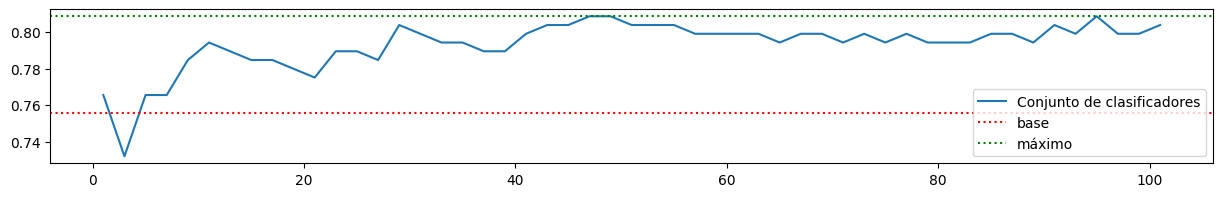

In [14]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

## Bagging en Sklearn

In [16]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(n_estimators=43)
bagging_model.fit(x_train, y_train)
bagging_model.score(x_test, y_test)

0.8229665071770335

---

# Boosting

El Boosting consiste en hacer que cada clasificador del conjunto intenta mejorar los errores de los anteriores.

- Cada dato tiene un peso asociado, que determina la probabilidad de ser elegido para construir el siguiente clasificador.
- El peso aumenta para los datos mal clasificados.
- El peso disminuye para los datos bien clasificados.
- El voto de los clasificadores es ponderado en base a su error.


In [17]:
NUM_CLASIFICADORES = 101

boosting_x = []
boosting_y = []
weights = np.ones(len(x_train.values))/len(x_train.values)
clasificadores = []
for _ in range(NUM_CLASIFICADORES):
  # Importante definir p=weights
  indices = np.random.choice(len(x_train.values), size=len(x_train.values), p=weights, replace=True)
  tree = DecisionTreeClassifier()
  tree.fit(x_train.values[indices], y_train.values[indices])
  clasificadores.append(tree)

  # Actualización de pesos, por ejemplo *2 a los fallos y /2 a los aciertos
  preds = tree.predict(x_train.values)
  fallos = np.where(preds != y_train)[0]
  aciertos = np.where(preds == y_train)[0]
  weights[fallos] *= 2
  weights[aciertos] /= 2
  weights /= weights.sum()

In [18]:
preds = []
for cl in conjunto_clasificadores:
  preds.append(cl.predict(x_test.values))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

np.float64(0.8038277511961722)

## Curva de accuracy según el número de clasificadores

In [19]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl in conjunto_clasificadores[:i]:
    preds.append(cl.predict(x_test.values))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

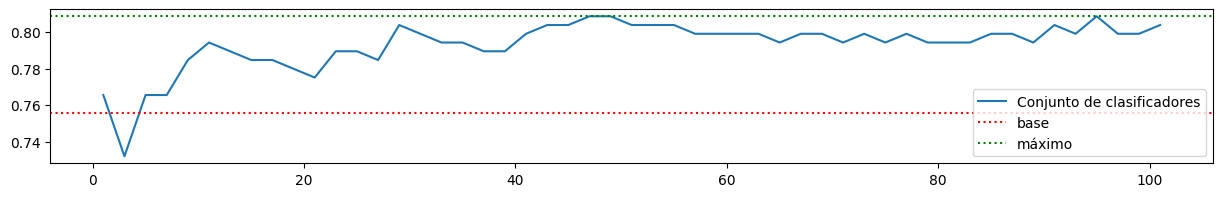

In [20]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

## Boosting en Sklearn

In [23]:
from sklearn.ensemble import AdaBoostClassifier

boosting = AdaBoostClassifier(n_estimators=41)
boosting.fit(x_train, y_train)
boosting.score(x_test, y_test)

0.8133971291866029

---

# Random Forest

En Random Forest, cada clasificador se entrena con un subconjunto distinto de los atributos usando bagging. Normalmente son árboles sin poda.

In [24]:
NUM_CLASIFICADORES = 101
NUM_ATRIBUTOS = len(x_train.columns)
NUM_ATRIBUTOS_RANDOM_FOREST = 24

bagging_x, bagging_y = bagging(NUM_CLASIFICADORES, x_train.values, y_train.values)
clasificadores = []
atributos = []
for i in range(NUM_CLASIFICADORES):
  attr = np.random.choice(len(x_train.columns), NUM_ATRIBUTOS_RANDOM_FOREST, replace=False)
  atributos.append(attr)
  data_x = bagging_x[i][:, attr]
  data_y = bagging_y[i]
  tree = DecisionTreeClassifier()
  tree.fit(data_x, data_y)
  clasificadores.append(tree)

In [25]:
preds = []
for cl, attr in zip(clasificadores, atributos):
  preds.append(cl.predict(x_test.values[:, attr]))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

np.float64(0.8229665071770335)

## Curva de accuracy según el número de clasificadores

In [26]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl, attr in zip(clasificadores[:i], atributos[:i]):
    preds.append(cl.predict(x_test.values[:, attr]))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

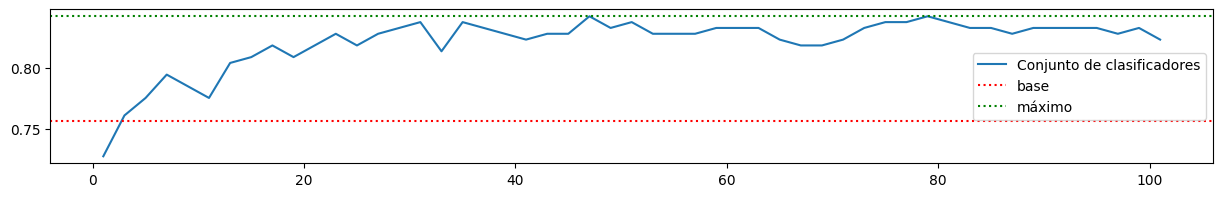

In [27]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

## Random Forest en Sklearn

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=79)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.8133971291866029

---

# Class Switching

Se alteran los datos modificando las clases aleatoriamente con probabilidad P.

In [30]:
P = 0.3
NUM_CLASIFICADORES = 101

class_switching = []
for _ in range(NUM_CLASIFICADORES):
  y_switch = np.copy(y_train)*1
  indices = np.where(np.random.rand(len(x_train.values)) <= P)[0]
  y_switch[indices] += 1
  y_switch = (y_switch % 2) == 1
  class_switching.append(y_switch)

In [31]:
clasificadores = []
for i in range(NUM_CLASIFICADORES):
  tree = DecisionTreeClassifier()
  tree.fit(x_train.values, class_switching[i])
  clasificadores.append(tree)

In [32]:
preds = []
for cl in clasificadores:
  preds.append(cl.predict(x_test.values))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

np.float64(0.784688995215311)

## Curva de accuracy según el número de clasificadores

In [33]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl in clasificadores[:i]:
    preds.append(cl.predict(x_test.values))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

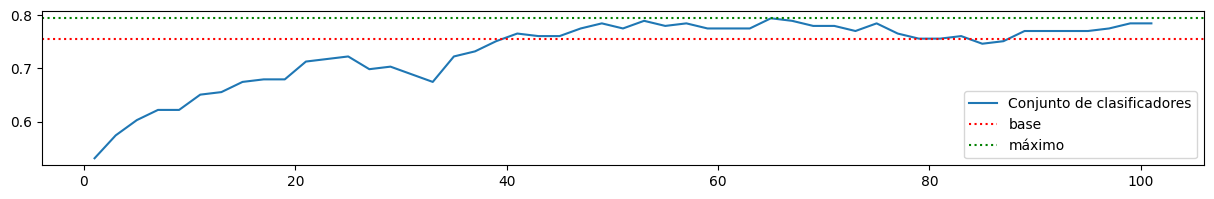

In [34]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

---

# Combinación de clasificadores

Esta estrategia consiste en entrenar diferentes modelos con diferentes hiperparámetros y cada uno es un clasificador.

In [35]:
clasificadores = []

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
clasificadores.append(knn)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)
clasificadores.append(nb)

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
clasificadores.append(tree)

In [37]:
preds = []
for cl in clasificadores:
  preds.append(cl.predict(x_test))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

np.float64(0.7177033492822966)